In [ ]:
from astropy.io import fits
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.stats
import astropy.table
from astropy.table import join
import astropy.wcs
import astropy.cosmology
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii
import scipy.integrate as integrate
import scipy.optimize as optimize
from astropy.cosmology import FlatLambdaCDM

In [ ]:
li=ascii.read(r"/content/Li data.txt")
li

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str4,float64,float64,float64,float64,float64
34,3.591921,-30.41574,2.07,7.72,-0.14,0.19,0.33,-0.04,0.05,2.82,0.15,0.87,0.03,0.85,0.02,8.03,0.02,3.04
245,3.599965,-30.40957,1.81,7.78,-0.17,0.19,0.39,-0.08,0.06,0.47,0.05,1.60,0.89,1.02,0.11,7.6,0.52,6.29
282,3.577672,-30.408856,2.26,7.05,-0.09,0.09,0.01,-0.01,0.01,0.45,0.06,0.69,0.05,0.48,0.03,8.13,0.03,2.31
614,3.618857,-30.403802,2.2,7.11,-0.08,0.08,0.19,-0.04,0.04,1.24,0.25,0.86,0.13,1.15,0.28,8.03,0.08,1.0
882,3.602338,-30.400736,1.81,8.58,-0.15,0.16,0.2,-0.04,0.08,0.64,0.08,0.04,0.08,0.63,0.08,8.52,0.05,2.23
1018,3.606238,-30.397984,2.28,6.89,-0.17,0.24,0.12,-0.03,0.05,1.05,0.1,1.68,0.61,0.8,0.07,7.55,0.36,1.78
1085,3.604176,-30.39717,2.07,9.37,-0.2,0.15,0.38,-0.04,0.05,3.93,0.26,0.16,0.03,0.75,0.09,8.44,0.02,1.85
1333,3.606056,-30.393533,2.18,8.42,-0.25,0.18,0.3,-0.07,0.09,1.48,0.16,0.80,0.06,1.13,0.11,8.07,0.03,1.68
1407,3.611638,-30.392479,2.28,7.45,-0.3,0.3,0.13,-0.03,0.04,0.86,0.08,1.03,0.10,1.05,0.09,7.93,0.06,1.53


In [ ]:
Li_data = astropy.table.Table({'ID': li['col1'],
                                  'R.A': li['col2'],
                                  'D.E': li['col3'],
                                  'Z': li['col4'],
                                  'logMstar':li['col5'],
                                  'e_Mstar':((-1*li['col6']+li['col7'])/2),
                                  'logSFR':li['col11'],
                                  'e_logSFR':li['col12']})


Li_data



ID,R.A,D.E,Z,logMstar,e_Mstar,logSFR,e_logSFR
int64,float64,float64,float64,float64,float64,float64,float64
34,3.591921,-30.41574,2.07,7.72,0.165,2.82,0.15
245,3.599965,-30.40957,1.81,7.78,0.18,0.47,0.05
282,3.577672,-30.408856,2.26,7.05,0.09,0.45,0.06
614,3.618857,-30.403802,2.2,7.11,0.08,1.24,0.25
882,3.602338,-30.400736,1.81,8.58,0.155,0.64,0.08
1018,3.606238,-30.397984,2.28,6.89,0.20500000000000002,1.05,0.1
1085,3.604176,-30.39717,2.07,9.37,0.175,3.93,0.26
1333,3.606056,-30.393533,2.18,8.42,0.215,1.48,0.16
1407,3.611638,-30.392479,2.28,7.45,0.3,0.86,0.08


In [ ]:
#function for fitting the values to a straight line of for y=mx+c
def linear_fit(x,y,co):
    A_transpose=np.matrix(np.ones(len(x)))
    A_transpose=np.vstack([A_transpose,x])
    A=A_transpose.transpose()
    Y=np.matrix(y)
    covar=np.diag(co*co)
    Y_transpose=Y.transpose()
    Cinv=np.linalg.inv(covar)
    B=np.matmul(A_transpose,Cinv)
    D=np.matmul(B,A)
    E=np.linalg.inv(D)
    F=np.matmul(B,Y_transpose)
    const=np.matmul(E,F)

    return(const,E)


<ipython-input-10-cef2c0c11df0>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b=float(low_p[0])
<ipython-input-10-cef2c0c11df0>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma=float(low_p[1])


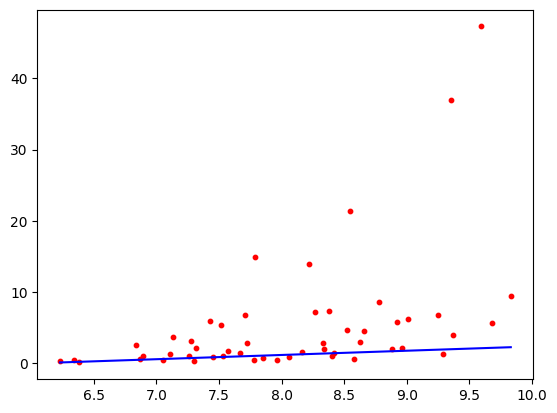

gamma =  0.596022834334522 ± 0.01907481676440342
b =  -3.611926555294322 ± 0.13855087934058274


In [ ]:
low_p,err_low_p=linear_fit(Li_data['logMstar'],Li_data['logSFR'],Li_data['e_logSFR'])

plt.scatter(Li_data['logMstar'],Li_data['logSFR'],color='red',s=10)
#plt.errorbar(x,y,co_low,fmt='o',color='r')

b=float(low_p[0])
gamma=float(low_p[1])




k = np.linspace(min(Li_data['logMstar']),max(Li_data['logMstar']),100)

l =(k*gamma)+b


plt.plot(k, l, color='blue')


plt.show()
residual=Li_data['logSFR']-((gamma*Li_data['logMstar'])+b)
delta_sqrd=np.mean((residual**2)-(Li_data['e_logSFR']**2))
print("gamma = ", gamma,'±', np.sqrt(err_low_p[1, 1]))
print("b = ", b ,'±', np.sqrt(err_low_p[0, 0]))
delta=np.sqrt(delta_sqrd)


In [ ]:
low=Li_data[Li_data['Z']>=(2.5)]
low

logMstar_mean = np.mean(low['logMstar'])
logMstar_std = np.std(low['logMstar'])


logSFR_mean = np.mean(low['logSFR'])
logSFR_std = np.std(low['logSFR'])

e_logSFR_mean = np.mean(low['e_logSFR'])
e_logSFR_std = np.std(low['e_logSFR'])

low['logMstar_norm'] = (low['logMstar'] - logMstar_mean) / logMstar_std
low['logSFR_norm'] = (low['logSFR'] - logSFR_mean) / logSFR_std
low['e_logSFR_norm'] = (low['e_logSFR'] - e_logSFR_mean) / e_logSFR_std
low

ID,R.A,D.E,Z,logMstar,e_Mstar,logSFR,e_logSFR,logMstar_norm,logSFR_norm,e_logSFR_norm
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
50,110.821398,-73.474602,2.98,8.78,0.08,8.66,1.42,0.49050645135195603,-0.04966584307507292,0.7674325615245319
1347,110.823498,-73.44444,3.37,8.22,0.065,14.0,1.28,-0.18356376400287958,0.43108751406249163,0.5650327650785016
1361,110.859711,-73.444213,2.73,9.01,0.07500000000000001,6.27,0.99,0.7673567183726933,-0.2648344804456309,0.14577604386886714
1424,110.828726,-73.442593,3.1,9.59,0.04,47.29,1.63,1.4655008699902032,3.4281435550942376,1.0710322561935774
1475,110.863244,-73.441489,2.73,8.33,0.105,2.9,0.51,-0.05115711455818012,-0.568231262009974,-0.5481661153746656
1491,110.859274,-73.44123,2.73,9.83,0.035,9.45,1.18,1.7543881051422765,0.02145684459134573,0.4204614819027655
1520,110.850517,-73.440461,3.04,7.71,0.11,6.77,0.9,-0.7974491387010356,-0.21982012116308738,0.015661889010704776
404,3.61346,-30.40686,2.85,6.84,0.07,2.56,0.35,-1.8446653661273007,-0.5988410263221036,-0.7794801684558433
434,3.607437,-30.406471,3.2,9.25,0.32999999999999996,6.79,1.03,1.0562439535247665,-0.21801954679178562,0.2036045571391616


In [ ]:
flux=ascii.read(r"/content/li2.txt")
flux
ha=flux['col4']*2.86
low['Fha']=ha
low
sfr_dash=(-55.0)+np.log10(4.6*low['Fha'])#taking flux in erg s-1 m-2
low['logSFR_dash']=sfr_dash
low
logSFRd_mean = np.mean(low['logSFR_dash'])
logSFRd_std = np.std(low['logSFR_dash'])
low['logSFR_dash_norm'] = (low['logSFR_dash'] - logSFRd_mean) / logSFRd_std
low


ID,R.A,D.E,Z,logMstar,e_Mstar,logSFR,e_logSFR,logMstar_norm,logSFR_norm,e_logSFR_norm,Fha,logSFR_dash,logSFR_dash_norm
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
50,110.821398,-73.474602,2.98,8.78,0.08,8.66,1.42,0.49050645135195603,-0.04966584307507292,0.7674325615245319,2.2022,-53.9943854100169,-0.034839194868657705
1347,110.823498,-73.44444,3.37,8.22,0.065,14.0,1.28,-0.18356376400287958,0.43108751406249163,0.5650327650785016,4.089799999999999,-53.72554009772432,0.7106586896959212
1361,110.859711,-73.444213,2.73,9.01,0.07500000000000001,6.27,0.99,0.7673567183726933,-0.2648344804456309,0.14577604386886714,3.3747999999999996,-53.80899412788326,0.47924381989090076
1424,110.828726,-73.442593,3.1,9.59,0.04,47.29,1.63,1.4655008699902032,3.4281435550942376,1.0710322561935774,13.499199999999998,-53.2069341365553,2.148733408861303
1475,110.863244,-73.441489,2.73,8.33,0.105,2.9,0.51,-0.05115711455818012,-0.568231262009974,-0.5481661153746656,1.3156,-54.21811830350781,-0.6552420480285513
1491,110.859274,-73.44123,2.73,9.83,0.035,9.45,1.18,1.7543881051422765,0.02145684459134573,0.4204614819027655,4.4044,-53.69335541435292,0.7999055996165434
1520,110.850517,-73.440461,3.04,7.71,0.11,6.77,0.9,-0.7974491387010356,-0.21982012116308738,0.015661889010704776,2.4596,-53.94637768394581,0.09828441410766184
404,3.61346,-30.40686,2.85,6.84,0.07,2.56,0.35,-1.8446653661273007,-0.5988410263221036,-0.7794801684558433,1.2584,-54.2374234587032,-0.7087745133582478
434,3.607437,-30.406471,3.2,9.25,0.32999999999999996,6.79,1.03,1.0562439535247665,-0.21801954679178562,0.2036045571391616,2.288,-53.97778614819744,0.011189930453331902


<ipython-input-19-871ed1abda61>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b=float(low_p[0])
<ipython-input-19-871ed1abda61>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma=float(low_p[1])
<ipython-input-19-871ed1abda61>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta=float(norm_p[0])
<ipython-input-19-871ed1abda61>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extrac

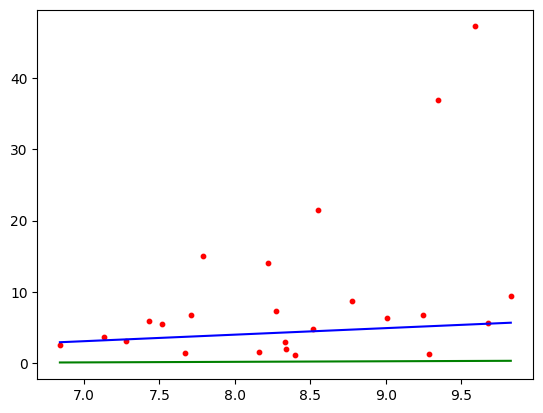

gamma =  0.917607968385984 ± 0.16096622844541378
b =  -3.364208493071885 ± 1.286013056697142
-0.47016177977436296 0.07854630879627555
0.11909588198183536 0.13372655529956023


In [ ]:
#fitting of the galaxies with z>5 and MUV>-19
low_p,err_low_p=linear_fit(low['logMstar'],low['logSFR'],low['e_logSFR'])
norm_p,err_norm_p=linear_fit(low['logMstar_norm'],low['logSFR_dash_norm'],low['e_logSFR'])
plt.scatter(low['logMstar'],low['logSFR'],color='red',s=10)
#plt.errorbar(x,y,co_low,fmt='o',color='r')

b=float(low_p[0])
gamma=float(low_p[1])

beta=float(norm_p[0])
gamma_norm=float(norm_p[1])

k = np.linspace(min(low['logMstar']),max(low['logMstar']),100)
l =(k*gamma)+b

#p=np.linspace(min(low['logMstar_norm']),max(low['logMstar_norm']),100)
q=(k*gamma_norm)+beta

plt.plot(k, l, color='blue')
plt.plot(k,q,color='green')



plt.show()
residual=low['logSFR']-((gamma*low['logMstar'])+b)
delta_sqrd=np.mean((residual**2)-(low['e_logSFR']**2))
print("gamma = ", gamma,'±', np.sqrt(err_low_p[1, 1]))
print("b = ", b ,'±', np.sqrt(err_low_p[0, 0]))
delta=np.sqrt(delta_sqrd)
print(beta,gamma_norm)
print(np.sqrt(err_norm_p[0, 0]),np.sqrt(err_norm_p[1, 1]))


In [ ]:
!pip install emcee
!pip install corner
!pip install multiprocessing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import emcee
import corner

import multiprocessing

In [ ]:
def Dl_LCDM(z, Omega_m):
    c = 299792.458
    H0 = 70
    Ez_inv = lambda zp: 1.0 / np.sqrt(Omega_m * (1 + zp) ** 3 + (1 - Omega_m))
    integral, _ = integrate.quad(Ez_inv, 0, z)
    return (c / H0) * (1 + z) * integral*3.086*(10**22)


In [ ]:
def Phi(logM_star, DL, beta, gamma):
    DL = np.array(DL)  # Convert to numpy array if not already
    return (beta) + (gamma * logM_star) + (( - 1) * (2 * np.log10(DL) + np.log10(4*np.pi)))

In [ ]:
# Log-likelihood function from Equation (5)
def log_likelihood(theta, logSFR_prime_obs, logM_star_obs, z_obs, DL_obs, logSFR_err, logM_star_err):
    beta, gamma, delta, Omega_m = theta


    if not (0.2 < Omega_m < 0.4):
        return -np.inf



    Dl_vals = np.array([Dl_LCDM(z, Omega_m) for z in z_obs])



    logSFR_model = Phi(logM_star_obs, Dl_vals, beta, gamma)


    s2 = logSFR_err**2 + (gamma**2) * logM_star_err**2 + delta**2


    logL = -0.5 * (np.sum(((logSFR_prime_obs - logSFR_model) ** 2 / s2) + np.log(2 * np.pi * s2)))

    return logL

In [ ]:
# Define log-prior function
def log_prior(theta):
    beta, gamma, delta, Omega_m = theta


    if -3 < beta < 3 and -2 < gamma <  2 and -2 < delta < 2 and 0.2 < Omega_m < 0.5:
        return 0.0
    return -np.inf


In [ ]:
def log_posterior(theta, logSFR_prime_obs, logM_star_obs, z_obs, DL_obs, logSFR_err, logM_star_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, logSFR_prime_obs, logM_star_obs, z_obs, DL_obs, logSFR_err, logM_star_err)


2
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [01:50<00:00, 45.35it/s]


Best-fit parameters:
β = 0.562, γ = 0.016, δ = -0.004, Ωm = 0.302


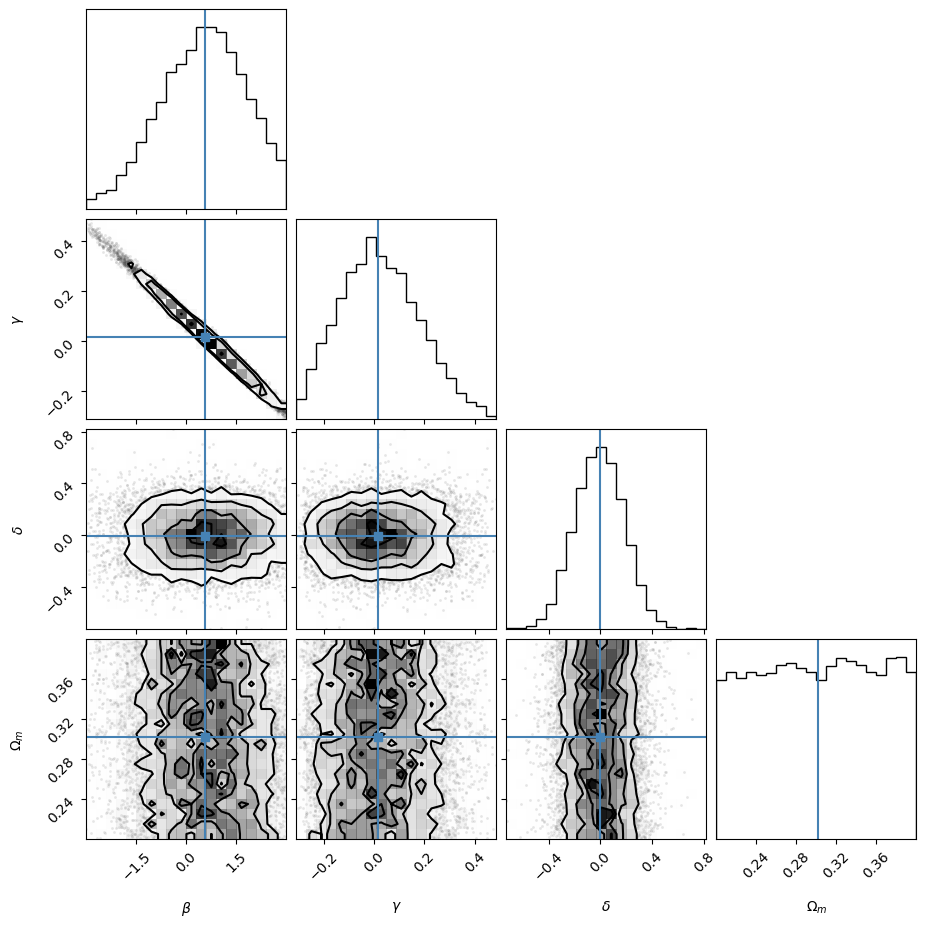

Autocorrelation time: [52.68004292 52.20818169 56.93346464 64.06386698]
Effective Sample Size: 141.664657686937


In [ ]:

c = 299792.458
H0 = 70


z_obs = low['Z']
DL_obs = np.array([Dl_LCDM(z, 0.3) for z in z_obs])
logSFR_prime_obs = low['logSFR_dash']
logM_star_obs = low['logMstar']
logSFR_err = low['e_logSFR']
logM_star_err =  low['e_Mstar']


ndim = 4
nwalkers = 20
nsteps = 5000



p0 = np.random.normal(loc=[-0.47, 0.075, 0.334, 0.3], scale=[0.1, 0.05, 0.05, 0.05], size=(nwalkers, ndim))
n_threads = multiprocessing.cpu_count()
print(n_threads)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior,
    args=(logSFR_prime_obs, logM_star_obs, z_obs, DL_obs, logSFR_err, logM_star_err)
)

print("Running MCMC...")
sampler.run_mcmc(p0, nsteps, progress=True)
samples = sampler.get_chain(discard=1000, thin=10, flat=True)

best_fit_params = np.median(samples, axis=0)
beta_best, gamma_best, delta_best, Omega_m_best = best_fit_params
low_beta=beta_best
low_gamma=gamma_best
low_delta=delta_best
low_Omega_m=Omega_m_best
print(f"Best-fit parameters:")
print(f"β = {beta_best:.3f}, γ = {gamma_best:.3f}, δ = {delta_best:.3f}, Ωm = {Omega_m_best:.3f}")

# Corner plot of the posterior distribution
fig = corner.corner(samples, labels=[r"$\beta$", r"$\gamma$", r"$\delta$", r"$\Omega_m$"], truths=best_fit_params)
plt.show()
try:
    tau = sampler.get_autocorr_time()
    print(f"Autocorrelation time: {tau}")
    print(f"Effective Sample Size: {len(samples) / np.mean(tau)}")
except:
    print("The chain may not have converged.")


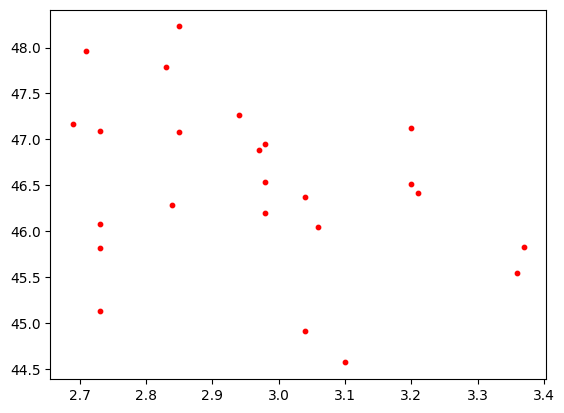

In [ ]:
z_obs = low['Z']
DL_obs = np.array([Dl_LCDM(z, 0.302) for z in z_obs])
f=low['logSFR_dash']-(0.016*(low['logMstar']-np.log10(4*np.pi*DL_obs**2)))-0.562-(0.016-1)*np.log10(4*np.pi)
f=f-((0.016-1)*(44+np.log10(3.086**2)))

dm=(2.5*f/(0.016-1))+25
plt.scatter(z_obs,dm,color='red',s=10)

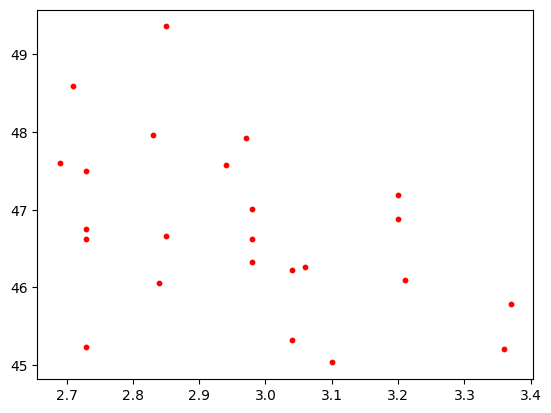

In [ ]:
z_obs = low['Z']
DL_obs = np.array([Dl_LCDM(z, 0.306) for z in z_obs])
f=low['logSFR_dash']-(0.189*(low['logMstar']-np.log10(4*np.pi*DL_obs**2)))+0.772-(0.189-1)*np.log10(4*np.pi)
f=f-((0.189-1)*(44+np.log10(3.086**2)))

dm=(2.5*f/(0.189-1))+25
plt.scatter(z_obs,dm,color='red',s=10)